In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="white")

COLOR_MAP = "colorblind"

sns.color_palette(COLOR_MAP)

COLORS = {
    "bigscape_blue": "#52A3A3",
    "dark_blue": "#0E75BB",
    "orange_i_found_on_bigscape_image": "#F7931E",
    "antismash_red": "#AA0000",
    "bigslice_grey": "#515154",
}

In [ ]:
# load performance for single run

partition_1_perf_1k = pd.read_csv("10000_partition_1_perf.csv")

/tmp/ipykernel_30021/1287143120.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.gca().legend().remove()


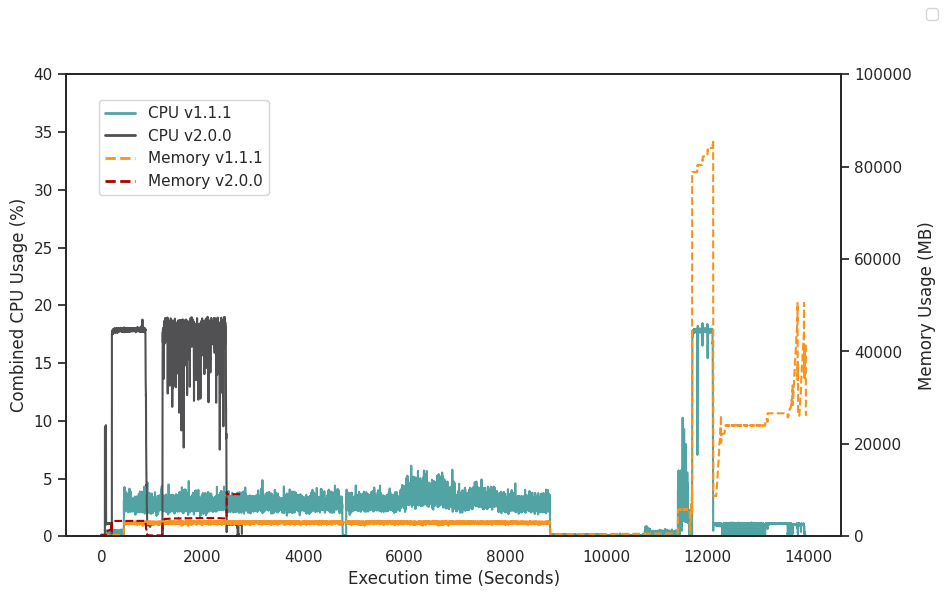

In [ ]:

perf_colors = [
    COLORS["bigscape_blue"],
    COLORS["bigslice_grey"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"],
]

# simple line chart - cpu
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=partition_1_perf_1k, x="seconds", y="cpu", hue="version", palette=perf_colors[:2], legend=False)
plt.xlabel("Execution time (Seconds)")
plt.ylabel("Combined CPU Usage (%)")

plt.ylim(0, 40)
lines, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend().remove()


ax2 = plt.twinx()
sns.lineplot(data=partition_1_perf_1k, x="seconds", y="mem_used_mb", hue="version", ax=ax2, palette=perf_colors[2:], legend=False)
ax2.lines[0].set_linestyle("--")
ax2.lines[1].set_linestyle("--")

ax2.set_ylim(0, 100000)
plt.ylabel("Memory Usage (MB)")

# create a fresh legend
text = ["CPU v1.1.1", "CPU v2.0.0", "Memory v1.1.1", "Memory v2.0.0"]

handles = [plt.Line2D([0], [0], color=perf_colors[i], linewidth=2, linestyle="--" if i > 1 else "-") for i in range(4)]
labels = text

legend = fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.15, 0.85))

# add legend to figure
fig.legend(lines, text, loc='upper right')

plt.savefig("performance_one_run.svg")

